### Exploring SNOMED Hierarchies

In [1]:
import pandas as pd
import networkx as nx
from itertools import combinations
from multiprocessing import Pool, Manager
import multiprocessing

In [2]:
dag_df = pd.read_csv('../data/DAGs_standardized.csv', dtype={'Exposure': str, 'Outcome':str})
concept_df = pd.read_csv('../Standardization/athena_vocabulary/CONCEPT.csv', sep='\t', dtype={'concept_code': str, 'concept_id': str}, low_memory=False)
concept_relationship_df = pd.read_csv('../Standardization/athena_vocabulary/CONCEPT_RELATIONSHIP.csv', sep='\t', dtype={'concept_id_1':str, 'concept_id_2': str}, low_memory=False)
concept_ancestor_df = pd.read_csv('../Standardization/athena_vocabulary/CONCEPT_ANCESTOR.csv', sep='\t',dtype={'ancestor_concept_id': str, 'descendant_concept_id': str}, low_memory=False)

Only select numeric terms that have been coded to SNOMED-CT

In [3]:
my_terms = set(dag_df[
    dag_df.Exposure.str.isdigit() & dag_df.Outcome.str.isdigit()]['Exposure']
    ).union(set(dag_df[dag_df.Exposure.str.isdigit() & dag_df.Outcome.str.isdigit()]['Outcome']))

Getting all snomed terms and relationships

In [4]:
snomed_concepts = concept_df[concept_df['vocabulary_id'] == 'SNOMED']
snomed_relationships = concept_relationship_df[
    (concept_relationship_df['concept_id_1'].isin(snomed_concepts['concept_id'])) &
    (concept_relationship_df['concept_id_2'].isin(snomed_concepts['concept_id'])) 
]

### Calculating distance between each term in the hierarchy

Determine the edges of the graph: what links are useful between terms?

In [5]:
useful_relationship_ids = [
    "Is a",                 
    "Subsumes",
    "Interprets of",            # Links specific measurements to conditions
    "Causative agent of",       # Etiological link
    "Has due to",               # Etiology relationships
    "Due to of",
    "Asso finding of",
    "Pathology of",             # Links to pathological processes
    "Has dir morph",            # Direct morphology
    "Has asso morph",           # Associated morphology
    "Occurs before",            # Temporal relationship
    "Follows",                  # Temporal relationship
    "Has manifestation",        # Links findings to manifestations
    "Has complication"          # Links to complications
]

selected_relationship_ids = useful_relationship_ids

Double check they all exist

In [6]:
for rel in useful_relationship_ids:
    if rel not in snomed_relationships.relationship_id.unique():
        print(rel)

Filter relationships

In [7]:
snomed_relationships_filtered = snomed_relationships[(snomed_relationships.relationship_id!='Has status')&(snomed_relationships.relationship_id!='Has Module')&(snomed_relationships.relationship_id!='Status of')&(snomed_relationships.relationship_id!='Module of')]
# snomed_relationships_filtered = snomed_relationships[snomed_relationships.relationship_id.isin(selected_relationship_ids)]

Create network

In [8]:
G = nx.DiGraph()

edges_with_attributes = zip(
    snomed_relationships_filtered['concept_id_1'],
    snomed_relationships_filtered['concept_id_2'],
    snomed_relationships_filtered['relationship_id']
)
G.add_edges_from((u, v, {'relationship_type': r}) for u, v, r in edges_with_attributes)

In [9]:
print(f"Number of nodes in G: {G.number_of_nodes()}")
print(f"Number of edges in G: {G.number_of_edges()}")

Number of nodes in G: 597858
Number of edges in G: 3879502


Are all terms in the network?

In [10]:
missing_terms = [term for term in my_terms if term not in G]
if missing_terms:
    print(f"Warning: These terms are missing from the graph: {missing_terms}")
else:
    print("All terms are present in the graph.")

All terms are present in the graph.


Delete nodes that dont carry relevant semantical meaning such as SNOMED CT Concept, CLinical Finding, etc. (top two levels of hierarchy)

In [11]:
root_term = '4008453'

for node in sorted(G.neighbors(root_term)):
    G.remove_node(node)
G.remove_node(root_term)

Can every node be reached (no matter of direction) by any other node?

In [12]:
nx.is_weakly_connected(G)

False

In [13]:
components = list(nx.weakly_connected_components(G))
relevant_components = [comp for comp in components if comp & my_terms]
len(relevant_components)

2

In [ ]:
def find_distance():
    return None

In [ ]:
distances = {}
for term1, term2 in combinations(my_terms, 2):
    distances[frozenset((term1, term2))] = find_distance()

### Distances

In [47]:
terms = sorted(my_terms)

distance_matrix2 = pd.DataFrame(index=terms, columns=terms, data=float('inf'))

for (term1, term2), distance in distances.items():
    distance_matrix2.at[term1, term2] = distance
    distance_matrix2.at[term2, term1] = distance

for term in my_terms:
    distance_matrix2.at[term, term] = 0

distance_matrix2

,134765,197672,198124,201820,255848,31317,313217,313459,316139,316866,...,44800078,44803656,44804450,44805124,46270002,46271022,46272492,604179,606770,81902
134765,0.0,6.0,8.0,8.0,9.0,9.0,10.0,7.0,7.0,7.0,...,6.0,9.0,9.0,15.0,8.0,8.0,6.0,8.0,6.0,8.0
197672,6.0,0.0,4.0,6.0,7.0,7.0,8.0,5.0,4.0,5.0,...,4.0,7.0,7.0,13.0,6.0,3.0,6.0,6.0,3.0,4.0
198124,8.0,4.0,0.0,6.0,7.0,8.0,8.0,6.0,7.0,6.0,...,6.0,9.0,9.0,15.0,8.0,2.0,8.0,7.0,6.0,3.0
201820,8.0,6.0,6.0,0.0,7.0,6.0,7.0,4.0,6.0,4.0,...,6.0,9.0,9.0,15.0,8.0,5.0,6.0,6.0,6.0,5.0
255848,9.0,7.0,7.0,7.0,0.0,9.0,8.0,5.0,7.0,7.0,...,7.0,10.0,10.0,16.0,9.0,8.0,7.0,7.0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46271022,8.0,3.0,2.0,5.0,8.0,7.0,8.0,5.0,5.0,5.0,...,6.0,9.0,9.0,15.0,8.0,0.0,6.0,6.0,2.0,4.0
46272492,6.0,6.0,8.0,6.0,7.0,8.0,8.0,5.0,7.0,5.0,...,6.0,9.0,9.0,15.0,8.0,6.0,0.0,6.0,6.0,6.0
604179,8.0,6.0,7.0,6.0,7.0,8.0,5.0,5.0,4.0,4.0,...,6.0,9.0,9.0,15.0,8.0,6.0,6.0,0.0,6.0,6.0
606770,6.0,3.0,6.0,6.0,7.0,7.0,8.0,5.0,3.0,5.0,...,4.0,7.0,7.0,13.0,6.0,2.0,6.0,6.0,0.0,6.0


### Hierarchical CLustering

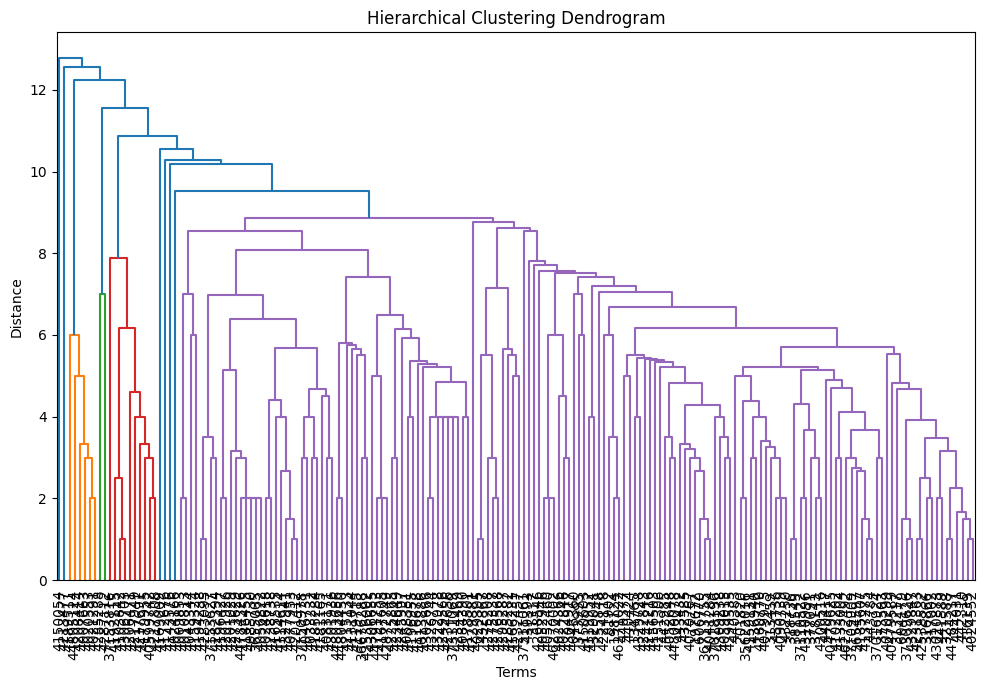

In [73]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster

import matplotlib.pyplot as plt

condensed_distances = squareform(distance_matrix2.values)

# Perform hierarchical clustering using the 'average' linkage method
linkage_matrix = linkage(condensed_distances, method='average')

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=distance_matrix2.index, leaf_rotation=90, leaf_font_size=10)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Terms")
plt.ylabel("Distance")
plt.tight_layout()

In [80]:
clusters = fcluster(linkage_matrix, t=6, criterion='distance')
cluster_df = pd.DataFrame({'term': distance_matrix2.index, 'cluster': clusters})
cluster_df_count = pd.DataFrame(cluster_df.cluster.value_counts()).reset_index()

In [83]:
cluster_df_named = cluster_df.merge(concept_df[['concept_id','concept_name']], how='left', left_on='term', right_on='concept_id').drop('concept_id', axis=1)
cluster_df_cluster_list = cluster_df_named.groupby('cluster')['concept_name'].apply(list).reset_index()
cluster_df_cluster_list.columns = ['cluster', 'concept_names']

In [84]:
lca_results = {}

for cluster_id, cluster_terms in cluster_df.groupby('cluster')['term']:
    if len(cluster_terms) > 1:

        cluster_terms = list(cluster_terms)
        lca = cluster_terms[0]

        for term in cluster_terms[1:]:
            # Find LCA of current LCA and the next term
            lca, _ = find_lca_and_distance(lca_pruned_graph, lca, term)

        lca_results[cluster_id] = lca
    else:
        # Single-term clusters have no LCA
        lca_results[cluster_id] = cluster_terms.iloc[0]

result_df = pd.DataFrame.from_dict(lca_results, orient='index').reset_index()

result_df.columns = ['cluster', 'athena_code']
result_df = result_df.merge(concept_df[['concept_id','concept_name']], how='left', left_on='athena_code', right_on='concept_id').drop('concept_id', axis=1)
result_df = result_df.merge(cluster_df_count, how='left', on='cluster')
result_df = result_df.merge(cluster_df_cluster_list, how='left', left_on='cluster', right_on='cluster')
result_df

,cluster,athena_code,concept_name,count,concept_names
0,1,4326835,Measurement of substance,6,"[Lipoprotein (a) measurement, Oxygen saturatio..."
1,2,4285288,Sympathetic nervous system structure,1,[Sympathetic nervous system structure]
2,3,4287112,Structure of perivascular space,1,[Structure of perivascular space]
3,4,4027306,Vascular sclerosis,3,"[Arteriosclerosis, Complicated atheromatous pl..."
4,5,4175951,Morphologically abnormal structure,6,"[Lesion, Hemorrhage, Infarct, Stenosis, Fractu..."
5,6,37153816,Malignant neoplasm,1,[Malignant neoplasm]
6,7,4274663,Smoke,2,"[Second hand cigarette smoke, Tobacco smoke]"
7,8,4022675,Substance,2,"[Clostridium botulinum toxin, Thiazolidinedione]"
8,9,4148948,Vascular surgery procedure,4,[Percutaneous transluminal procedure on blood ...
9,10,4322976,Procedure,9,"[Platelet aggregation inhibitor therapy, Antic..."


In [89]:
for i in result_df[result_df.cluster==1].concept_names:
 print(i)

['Lipoprotein (a) measurement', 'Oxygen saturation measurement', 'Troponin measurement', 'N terminal pro-brain natriuretic peptide level', 'C-reactive protein measurement', 'High sensitivity cardiac troponin T measurement']
